The code is modified from one of the PyTorch tutorials.
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import sklearn.metrics
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
from efficientnet_pytorch import EfficientNet

plt.ion()   # interactive mode

# load data

In [2]:
data_dir = 'kaggle_data'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Use cuda: {}'.format(torch.cuda.is_available()))

Use cuda: True


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        torchvision.transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ColorJitter(0.2,0.2,0.2),
        transforms.RandomAffine(degrees=2, translate=(0.15,0.1),scale=(0.75,1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
#set batch size
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

Visualize a few images

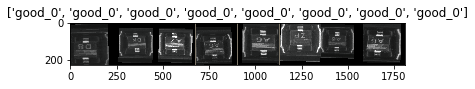

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

train the model and store the best weights

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # preds is argmax of the output vector
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualize the model predictions. Get a few images and predict

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
def evaluate(model, phase='val'):
    # output auc score of the model
    
    n = dataset_sizes[phase]
    y_true = np.zeros([n,1])
    y_score = np.zeros([n,1])
    images_so_far = 0
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # the score of the class with the greater label
        scores = outputs[:,1] 
        
        for j in range(inputs.size()[0]):
            y_true[images_so_far] = labels.cpu().data[j]
            y_score[images_so_far] = scores.cpu().data[j]
            images_so_far +=1
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    print('Area under ROC curve: {}'.format(auc))

# Train Resnet18

In [4]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# checkpoint_dir = 'resnet_checkpoints'
# if not os.listdir(checkpoint_dir):
#     list_of_files = glob.glob(os.path.join(checkpoint_dir,'*.pt'))
#     latest_file = max(list_of_files, key=os.path.getctime)
#     model_ft.load_state_dict(torch.load(latest_file))
    
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)
torch.save(model_ft.state_dict(), 'new.pt')

Epoch 0/13
----------
train Loss: 0.1548 Acc: 0.9509
val Loss: 0.1362 Acc: 0.9575

Epoch 1/13
----------
train Loss: 0.1011 Acc: 0.9706
val Loss: 0.0974 Acc: 0.9710

Epoch 2/13
----------
train Loss: 0.0763 Acc: 0.9780
val Loss: 0.0922 Acc: 0.9720

Epoch 3/13
----------
train Loss: 0.0677 Acc: 0.9801
val Loss: 0.1200 Acc: 0.9611

Epoch 4/13
----------
train Loss: 0.0615 Acc: 0.9825
val Loss: 0.0752 Acc: 0.9792

Epoch 5/13
----------
train Loss: 0.0550 Acc: 0.9836
val Loss: 0.0809 Acc: 0.9779

Epoch 6/13
----------
train Loss: 0.0530 Acc: 0.9848
val Loss: 0.0768 Acc: 0.9759

Epoch 7/13
----------
train Loss: 0.0386 Acc: 0.9888
val Loss: 0.0624 Acc: 0.9815

Epoch 8/13
----------
train Loss: 0.0333 Acc: 0.9898
val Loss: 0.0595 Acc: 0.9832

Epoch 9/13
----------
train Loss: 0.0328 Acc: 0.9903
val Loss: 0.0609 Acc: 0.9802

Epoch 10/13
----------
train Loss: 0.0317 Acc: 0.9906
val Loss: 0.0611 Acc: 0.9819

Epoch 11/13
----------
train Loss: 0.0300 Acc: 0.9911
val Loss: 0.0564 Acc: 0.9812

Ep

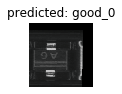

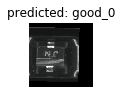

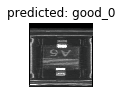

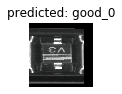

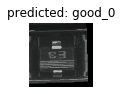

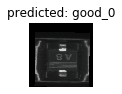

In [20]:
visualize_model(model_ft)

# Reload Resnet18 model from checkpoint

In [31]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load('new.pt'))
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Calculate AUC score of trained Resnet18 on validation set

In [19]:
evaluate(model_ft)


Area under ROC curve: 0.9882592428821159


# Resnet18 as fixed feature extractor

In [22]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [24]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
torch.save(model_ft.state_dict(), 'model_conv.pt')

Epoch 0/24
----------
train Loss: 0.4792 Acc: 0.7912
val Loss: 0.3562 Acc: 0.8727

Epoch 1/24
----------
train Loss: 0.4601 Acc: 0.8045
val Loss: 0.3956 Acc: 0.8444

Epoch 2/24
----------
train Loss: 0.4745 Acc: 0.7963
val Loss: 0.3855 Acc: 0.8549

Epoch 3/24
----------
train Loss: 0.4749 Acc: 0.8006
val Loss: 0.4071 Acc: 0.8417

Epoch 4/24
----------
train Loss: 0.4668 Acc: 0.8038
val Loss: 0.3610 Acc: 0.8892

Epoch 5/24
----------
train Loss: 0.4772 Acc: 0.8006
val Loss: 0.3437 Acc: 0.8965

Epoch 6/24
----------
train Loss: 0.4775 Acc: 0.7983
val Loss: 0.3998 Acc: 0.8473

Epoch 7/24
----------
train Loss: 0.4118 Acc: 0.8246
val Loss: 0.3835 Acc: 0.8440

Epoch 8/24
----------
train Loss: 0.4082 Acc: 0.8283
val Loss: 0.3714 Acc: 0.8520

Epoch 9/24
----------
train Loss: 0.4058 Acc: 0.8293
val Loss: 0.4412 Acc: 0.8124

Epoch 10/24
----------
train Loss: 0.4078 Acc: 0.8264
val Loss: 0.3527 Acc: 0.8866

Epoch 11/24
----------
train Loss: 0.4035 Acc: 0.8296
val Loss: 0.3986 Acc: 0.8454

Ep

# Try Resnet50 transfer learning(same procedures as Resnet18 but best result)

The result of Resnet50 in this module outperforms all the models and datasets we have tried.

In [5]:
model_ft50 = models.resnet50(pretrained=True)
num_ftrs = model_ft50.fc.in_features
print(num_ftrs)
    
model_ft50.fc = nn.Linear(num_ftrs, 2)

model_ft50 = model_ft50.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

2048


In [9]:
model_ft50 = train_model(model_ft50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)

Epoch 0/13
----------
train Loss: 0.1771 Acc: 0.9452
val Loss: 0.0825 Acc: 0.9749

Epoch 1/13
----------
train Loss: 0.0975 Acc: 0.9712
val Loss: 0.0831 Acc: 0.9740

Epoch 2/13
----------
train Loss: 0.0822 Acc: 0.9762
val Loss: 0.0679 Acc: 0.9799

Epoch 3/13
----------
train Loss: 0.0716 Acc: 0.9802
val Loss: 0.0737 Acc: 0.9792

Epoch 4/13
----------
train Loss: 0.0693 Acc: 0.9801
val Loss: 0.0611 Acc: 0.9825

Epoch 5/13
----------
train Loss: 0.0632 Acc: 0.9815
val Loss: 0.0680 Acc: 0.9825

Epoch 6/13
----------
train Loss: 0.0609 Acc: 0.9821
val Loss: 0.0600 Acc: 0.9845

Epoch 7/13
----------
train Loss: 0.0463 Acc: 0.9865
val Loss: 0.0561 Acc: 0.9858

Epoch 8/13
----------
train Loss: 0.0428 Acc: 0.9868
val Loss: 0.0572 Acc: 0.9838

Epoch 9/13
----------
train Loss: 0.0396 Acc: 0.9882
val Loss: 0.0512 Acc: 0.9871

Epoch 10/13
----------
train Loss: 0.0386 Acc: 0.9882
val Loss: 0.0599 Acc: 0.9852

Epoch 11/13
----------
train Loss: 0.0399 Acc: 0.9878
val Loss: 0.0566 Acc: 0.9852

Ep

NameError: name 'model_ft' is not defined

In [10]:
torch.save(model_ft50.state_dict(), 'new50.pt')

In [33]:
print(num_ftrs)

512


# Use training set "kaggle_data_normal" instead, which is filtered by anomaly filtering from "kaggle_data"

Lyu provided me with two datasets filtered from the dataset downloaded from Kaggle. The first one has the problem that too many "bad" samples were counted as outliers. In the second one, only the samples that both filtering methods consider as outliers were kicked out. I tried both datasets and augmented the first dataset using image transformations like before, the second using both image transformations and the images generated by styleGAN. The first and second try was on the first dataset that he provided. The third try was on the second dataset. However, they didn't improve the best result. 

In [7]:
# ! Before running this module,
# change the variable data_dir from "kaggle_data" to "kaggle_data_normal" 
# and rerun the code from top to function "train_model", and 
# also the first cell after "Try Resnet50 transfer learning(same procedures as Resnet18)"



# load the weights
model_ft50.load_state_dict(torch.load('new50.pt'))
model_ft50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [8]:
# train on the filtered dataset
model_ft50 = train_model(model_ft50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)

Epoch 0/13
----------
train Loss: 0.0453 Acc: 0.9869
val Loss: 0.0578 Acc: 0.9852

Epoch 1/13
----------
train Loss: 0.0414 Acc: 0.9880
val Loss: 0.0855 Acc: 0.9773

Epoch 2/13
----------
train Loss: 0.0415 Acc: 0.9882
val Loss: 0.0595 Acc: 0.9835

Epoch 3/13
----------
train Loss: 0.0377 Acc: 0.9894
val Loss: 0.0587 Acc: 0.9858

Epoch 4/13
----------
train Loss: 0.0369 Acc: 0.9890
val Loss: 0.0739 Acc: 0.9773

Epoch 5/13
----------
train Loss: 0.0359 Acc: 0.9892
val Loss: 0.0607 Acc: 0.9835

Epoch 6/13
----------
train Loss: 0.0342 Acc: 0.9896
val Loss: 0.0763 Acc: 0.9819

Epoch 7/13
----------
train Loss: 0.0255 Acc: 0.9924
val Loss: 0.0593 Acc: 0.9855

Epoch 8/13
----------
train Loss: 0.0206 Acc: 0.9937
val Loss: 0.0661 Acc: 0.9838

Epoch 9/13
----------
train Loss: 0.0210 Acc: 0.9933
val Loss: 0.0702 Acc: 0.9832

Epoch 10/13
----------
train Loss: 0.0189 Acc: 0.9943
val Loss: 0.0654 Acc: 0.9815

Epoch 11/13
----------
train Loss: 0.0173 Acc: 0.9946
val Loss: 0.0728 Acc: 0.9835

Ep

AttributeError: 'ResNet' object has no attribute 'state'

In [9]:
torch.save(model_ft50.state_dict(), '50_normal_14_epoch')

In [6]:
# The model with pretraied weights
model_ft50 = train_model(model_ft50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)
torch.save(model_ft50.state_dict(), '50_normal_14_epoch_from_pretrained')

Epoch 0/13
----------
train Loss: 0.1638 Acc: 0.9502
val Loss: 0.1025 Acc: 0.9700

Epoch 1/13
----------
train Loss: 0.0887 Acc: 0.9754
val Loss: 0.0800 Acc: 0.9812

Epoch 2/13
----------
train Loss: 0.0746 Acc: 0.9793
val Loss: 0.0783 Acc: 0.9749

Epoch 3/13
----------
train Loss: 0.0624 Acc: 0.9819
val Loss: 0.0784 Acc: 0.9782

Epoch 4/13
----------
train Loss: 0.0579 Acc: 0.9839
val Loss: 0.0752 Acc: 0.9786

Epoch 5/13
----------
train Loss: 0.0561 Acc: 0.9846
val Loss: 0.0674 Acc: 0.9809

Epoch 6/13
----------
train Loss: 0.0524 Acc: 0.9850
val Loss: 0.0655 Acc: 0.9805

Epoch 7/13
----------
train Loss: 0.0372 Acc: 0.9893
val Loss: 0.0614 Acc: 0.9819

Epoch 8/13
----------
train Loss: 0.0348 Acc: 0.9899
val Loss: 0.0606 Acc: 0.9829

Epoch 9/13
----------
train Loss: 0.0334 Acc: 0.9909
val Loss: 0.0565 Acc: 0.9832

Epoch 10/13
----------
train Loss: 0.0317 Acc: 0.9906
val Loss: 0.0583 Acc: 0.9845

Epoch 11/13
----------
train Loss: 0.0305 Acc: 0.9912
val Loss: 0.0589 Acc: 0.9835

Ep

In [10]:
# (Replicated code but on the second dataset) since I don't want to erase the previous trainning outputs) The model with pretraied weights
model_ft50 = train_model(model_ft50, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)
torch.save(model_ft50.state_dict(), '50_final_normal_14_epoch_from_pretrained')

Epoch 0/13
----------
train Loss: 0.1824 Acc: 0.9403
val Loss: 0.0854 Acc: 0.9733

Epoch 1/13
----------
train Loss: 0.0847 Acc: 0.9757
val Loss: 0.0857 Acc: 0.9759

Epoch 2/13
----------
train Loss: 0.0665 Acc: 0.9819
val Loss: 0.0736 Acc: 0.9792

Epoch 3/13
----------
train Loss: 0.0561 Acc: 0.9830
val Loss: 0.0633 Acc: 0.9819

Epoch 4/13
----------
train Loss: 0.0512 Acc: 0.9849
val Loss: 0.1031 Acc: 0.9746

Epoch 5/13
----------
train Loss: 0.0466 Acc: 0.9863
val Loss: 0.0733 Acc: 0.9782

Epoch 6/13
----------
train Loss: 0.0425 Acc: 0.9876
val Loss: 0.0716 Acc: 0.9812

Epoch 7/13
----------
train Loss: 0.0306 Acc: 0.9913
val Loss: 0.0583 Acc: 0.9835

Epoch 8/13
----------
train Loss: 0.0278 Acc: 0.9915
val Loss: 0.0600 Acc: 0.9835

Epoch 9/13
----------
train Loss: 0.0256 Acc: 0.9926
val Loss: 0.0573 Acc: 0.9835

Epoch 10/13
----------
train Loss: 0.0258 Acc: 0.9921
val Loss: 0.0584 Acc: 0.9842

Epoch 11/13
----------
train Loss: 0.0242 Acc: 0.9932
val Loss: 0.0512 Acc: 0.9848

Ep

# Transfer learning of EfficentNet (originaly augmented dataset: "kaggle_data")

In [4]:
model_ft_eft = EfficientNet.from_pretrained('efficientnet-b4')


Downloading: "http://storage.googleapis.com/public-models/efficientnet/efficientnet-b4-6ed6700e.pth" to /home/cly/.cache/torch/checkpoints/efficientnet-b4-6ed6700e.pth
100.0%


Loaded pretrained weights for efficientnet-b4


In [7]:
print(model_ft_eft)
num_ftrs = model_ft_eft._fc.in_features
model_ft_eft._fc = nn.Linear(num_ftrs, 2, bias=True)

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [9]:
model_ft_eft = model_ft_eft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft_eft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft_eft = train_model(model_ft_eft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=14)

Epoch 0/13
----------
train Loss: 0.2246 Acc: 0.9300
val Loss: 0.1023 Acc: 0.9683

Epoch 1/13
----------
train Loss: 0.1119 Acc: 0.9690
val Loss: 0.0765 Acc: 0.9766

Epoch 2/13
----------
train Loss: 0.0844 Acc: 0.9759
val Loss: 0.0763 Acc: 0.9763

Epoch 3/13
----------
train Loss: 0.0714 Acc: 0.9791
val Loss: 0.0733 Acc: 0.9805

Epoch 4/13
----------
train Loss: 0.0664 Acc: 0.9818
val Loss: 0.0687 Acc: 0.9812

Epoch 5/13
----------
train Loss: 0.0599 Acc: 0.9829
val Loss: 0.0681 Acc: 0.9799

Epoch 6/13
----------
train Loss: 0.0575 Acc: 0.9831
val Loss: 0.0631 Acc: 0.9829

Epoch 7/13
----------
train Loss: 0.0485 Acc: 0.9854
val Loss: 0.0595 Acc: 0.9822

Epoch 8/13
----------
train Loss: 0.0481 Acc: 0.9864
val Loss: 0.0596 Acc: 0.9829

Epoch 9/13
----------
train Loss: 0.0471 Acc: 0.9861
val Loss: 0.0569 Acc: 0.9838

Epoch 10/13
----------
train Loss: 0.0444 Acc: 0.9873
val Loss: 0.0682 Acc: 0.9809

Epoch 11/13
----------
train Loss: 0.0427 Acc: 0.9873
val Loss: 0.0607 Acc: 0.9832

Ep

The trainning result shows that EfficientNet seems not efficient nor accurate for this dataset, compared to Resnet50, despite the praise on its performance in some experiments